## find threshhold for classification glaucoma and non-glaucoma

In [2]:
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import string
%matplotlib inline 
from PIL import Image

## get ground truth CDRs

In [3]:
def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.

    Input:
        binary_segmentation: a boolean 2D numpy array representing a region of interest.
    Output:
        diameter: the vertical diameter of the structure, defined as the largest diameter between the upper and the lower interfaces
    '''

    # turn the variable to boolean, just in case
    binary_segmentation = np.asarray(binary_segmentation, dtype=np.bool)
    
    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=0)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter)

    # return it
    return float(diameter)


def cal_cdr(path):
    cdr, CDR = [], {}
    for root, dirs, files in os.walk(path):
        for image_path in files:
    #         print(image_path)
    #         print(os.path.splitext(image_path))
            if os.path.splitext(image_path)[-1] == '.png':
#                 print(os.path.join(root, image_path))
                image = np.array(Image.open(os.path.join(root, image_path)))

                # compute the cup diameter
                cup_diameter = vertical_diameter(image==0)

                # compute the disc diameter
                disc_diameter = vertical_diameter(image<2)

                cdr.append(cup_diameter / disc_diameter)
#                 if (cup_diameter / disc_diameter > 1):
#                     plt.imshow(image)
                
                CDR[os.path.splitext(image_path)[0]] = cup_diameter / disc_diameter

    CDR['mean'] = np.mean(np.array(cdr))
    CDR['max'] = np.max(np.array(cdr))
    CDR['min'] = np.min(np.array(cdr))
    
    return CDR


gt_folder = 'glaucoma/Disc_Cup_Masks'
pos_cdr = cal_cdr(os.path.join(gt_folder, 'Glaucoma'))
neg_cdr = cal_cdr(os.path.join(gt_folder, 'Non-Glaucoma'))
test_cdr = cal_cdr('glaucoma/gt400')

# print('Glaucoma CDR:', pos_cdr)
# print('Non-Glaucoma CDR:', neg_cdr)
print('Test400 CDR:', test_cdr)

Test400 CDR: {'T0283': 0.3611111111111111, 'T0297': 0.46153846153846156, 'T0268': 0.47058823529411764, 'T0240': 0.6111111111111112, 'T0254': 0.5789473684210527, 'T0308': 0.375, 'T0334': 0.5384615384615384, 'T0320': 0.5581395348837209, 'T0321': 0.47619047619047616, 'T0335': 0.42105263157894735, 'T0309': 0.5384615384615384, 'T0255': 0.40540540540540543, 'T0241': 0.4857142857142857, 'T0269': 0.40476190476190477, 'T0296': 0.525, 'T0282': 0.3939393939393939, 'T0294': 0.5142857142857142, 'T0280': 0.2857142857142857, 'T0257': 0.5128205128205128, 'T0243': 0.4186046511627907, 'T0323': 0.5135135135135135, 'T0337': 0.3939393939393939, 'T0336': 0.47368421052631576, 'T0322': 0.5277777777777778, 'T0242': 0.40625, 'T0256': 0.3888888888888889, 'T0281': 0.35294117647058826, 'T0295': 0.6571428571428571, 'T0291': 0.5897435897435898, 'T0285': 0.525, 'T0252': 0.3409090909090909, 'T0246': 0.3684210526315789, 'T0326': 0.4722222222222222, 'T0332': 0.37142857142857144, 'T0333': 0.34285714285714286, 'T0327': 0.

## Test mean square error with ground truth CDR

In [5]:
def moving_average(data, coe=0.85):
    for i in range(1, len(data)):
        data[i] = data[i-1] * coe + data[i] * (1-coe)
    return data

step 0, loss = 0.12637142580988767
step 500, loss = 0.02307230572810971
step 1000, loss = 0.03780239609244811
step 1500, loss = 0.011334186745897638
step 2000, loss = 0.05216615751384907
step 2500, loss = 0.01350469604879914
step 3000, loss = 0.013429021083093953
step 3500, loss = 0.02871265908109537
step 4000, loss = 0.01975278593848903
step 4500, loss = 0.01189709537607938
step 5000, loss = 0.011443363211500301
step 5500, loss = 0.01155573697016298
step 6000, loss = 0.038346435040105875
step 6500, loss = 0.028239785769243575
step 7000, loss = 0.0412651998771247
step 7500, loss = 0.039253246386678396


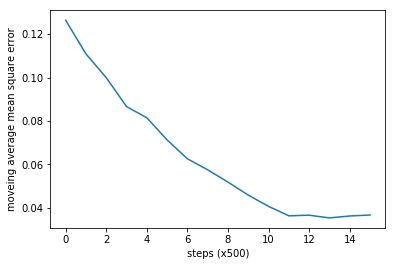

In [6]:
transfer_res = '../transfer_res_2/'

gt_cdr = []


def cal_cdr_loss(image_path, image_name):
    image_name = os.path.splitext(image_name)[0]
    image = np.array(Image.open(image_path))
    # compute the cup diameter
    cup_diameter = vertical_diameter(image==0)
    # compute the disc diameter
    disc_diameter = vertical_diameter(image<255)
    cdr = cup_diameter / disc_diameter
    return (cdr - test_cdr[image_name])**2
#     if (cup_diameter / disc_diameter > 1):
#         plt.imshow(image)


for root, dirs, files in os.walk(transfer_res):
#     print(root, dirs, files)
    losses = []
    for i in range(0, 8000, 500):
        loss = []
        for image_path in files:
            if (os.path.splitext(image_path)[-1] == '.png'):
                step, image_name = int(image_path.split('_')[0]), image_path.split('_')[1]
                if (step == i): 
                    loss.append(cal_cdr_loss(os.path.join(root, image_path), image_name))
        loss = np.mean(np.array(loss))
        losses.append(loss)
        print('step {}, loss = {}'.format(i, loss))
    
plt.xlabel('steps (x500)')
plt.ylabel('moveing average mean square error')
plt.plot(moving_average(losses))

step 0, loss = 0.1185856713692497
step 10, loss = 0.10219632807863327
step 20, loss = 0.01611799512883316
step 30, loss = 0.13210878786198932
step 40, loss = 0.05519463410939891
step 50, loss = 0.024389620963947076
step 60, loss = 0.025928059293065964
step 70, loss = 0.03201742442475146
step 80, loss = 0.24688421890999301
step 90, loss = 0.2601384846239246
step 100, loss = 0.14167576789804726
step 110, loss = 0.009479631859428156
step 120, loss = 0.06056724271963864
step 130, loss = 0.1058604665667559
step 140, loss = 0.18186203804222875
step 150, loss = 0.1126752353595096
step 160, loss = 0.015620931329330503
step 170, loss = 0.009218135410921922
step 180, loss = 0.010303088486588348
step 190, loss = 0.019662110994418877


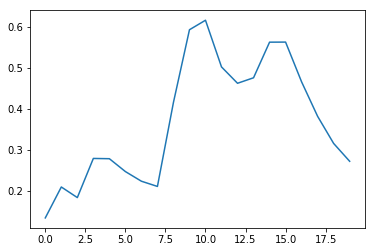

In [7]:
transfer_res = '../transfer_res_4/'

gt_cdr = []


def cal_cdr_loss(image_path, image_name):
    image_name = os.path.splitext(image_name)[0]
    image = np.array(Image.open(image_path))
    # compute the cup diameter
    cup_diameter = vertical_diameter(image==0)
    # compute the disc diameter
    disc_diameter = vertical_diameter(image<255)
    cdr = cup_diameter / disc_diameter
    return (cdr - test_cdr[image_name])**2
#     if (cup_diameter / disc_diameter > 1):
#         plt.imshow(image)


for root, dirs, files in os.walk(transfer_res):
#     print(root, dirs, files)
    losses = []
    for i in range(0, 200, 10):
        loss = []
        for image_path in files:
            if (os.path.splitext(image_path)[-1] == '.png'):
                step, image_name = int(image_path.split('_')[0]), image_path.split('_')[1]
                if (step == i): 
                    loss.append(cal_cdr_loss(os.path.join(root, image_path), image_name))
        loss = np.mean(np.array(loss))
        losses.append(loss)
        print('step {}, loss = {}'.format(i, loss))
    
    for i in range(len(losses)):
        losses[i] = losses[i-1] * 0.8 + losses[i]
    plt.plot(losses)

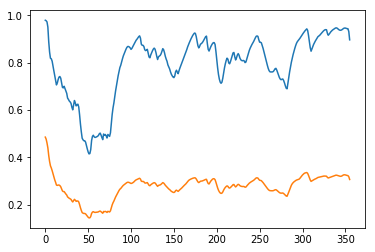

In [8]:
acc, iu = [], []
    
with open('results.txt') as f:
    for line in f.readlines():
#         print(line)
        if 'acc' in line:
            acc.append(float(line.split()[-1]))
        if 'mean IU' in line:
            iu.append(float(line.split()[-1]))

plt.plot(moving_average(acc, coe=0.9), label='Acc')
plt.plot(moving_average(iu, coe=0.9), label='IoU')